# Exploring Focal Plane Calibrations

Petal locations with updated calibrations (0, 1, 2, 3, 4, 5, 9)

Accessing the DB (read-only) requires being at NERSC, and credentials in a `$HOME/.pgpass` file, with details
available on the DESI wiki at https://desi.lbl.gov/trac/wiki/Pipeline/RawDataTransfer#OperationsDatabase .

Currently this notebook is comparing to the design parameters, not the lab metrology.

In [1]:
%pylab inline
import numpy as np
import psycopg2
import desimodel.io
import desimodel.focalplane
import datetime

from astropy.table import Table
from astropy.stats import sigma_clipped_stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_petal_calib(petal_loc, firstlast='last'):
    '''
    returns Table of calibration data for the requested petal location
    '''
    #- which PETAL_ID is plugged into which PETAL_LOC?
    #- petal_loc2id[loc] = id
    #- petal_id2loc[id] = loc
    #- From DESI-5286
    petal_loc2id = {2:6, 9:9, 0:4, 3:3, 8:7, 4:8, 6:11, 7:2, 5:10, 1:5}
    petal_id2loc = dict()
    for ploc, pid in petal_loc2id.items():
        petal_id2loc[pid] = ploc
    
    petal_id = petal_loc2id[petal_loc]
    print('Getting calib for petal_id={} installed at petal_loc={}'.format(petal_id, petal_loc))
    
    if firstlast == 'last':
        minmax = 'max'
    elif firstlast == 'first':
        minmax = 'min'
    else:
        raise ValueError('firstlast should be "first" or "last"')
    
    query = """
    select t.petal_id, t.device_loc, t.pos_id, t.time_recorded,
        t.length_r1, t.length_r2, t.offset_x, t.offset_y
    from posmovedb.positioner_calibration_p{petal_id} t
    inner join (
        select device_loc, {minmax}(time_recorded) as MaxDate
        from posmovedb.positioner_calibration_p{petal_id}
        group by device_loc
    ) tm on t.device_loc = tm.device_loc and t.time_recorded = tm.MaxDate
    """.format(petal_id = petal_id, minmax=minmax)

    comm = psycopg2.connect(host='db.replicator.dev-cattle.stable.spin.nersc.org', port=60042,
                           database='desi_dev', user='desi_reader')

    cx = comm.cursor()
    cx.execute(query)
    results = cx.fetchall()

    tx = Table(rows=results,
               names=['petal_id', 'device_loc', 'pos_id', 'time_recorded',
                      'r1', 'r2', 'x', 'y'],
               dtype=[int, int, str, datetime.datetime, float, float, float, float])

    tx.meta['PETAL_ID'] = petal_id
    tx.meta['PETAL_LOC'] = petal_loc

    return tx

In [3]:
t0 = get_petal_calib(0)

Getting calib for petal_id=4 installed at petal_loc=0


In [4]:
#- Get design locations from desimodel (which got them from DESI-0530)
focalplane = desimodel.io.load_deviceloc()

def plot_petal_calib(data):
    global fp
    
    #- Trim to just the POS and ETC for the requested petal
    petal_id = data.meta['PETAL_ID']
    petal_loc = data.meta['PETAL_LOC']
    ii = focalplane['PETAL'] == petal_loc
    ii &= (focalplane['DEVICE_TYPE'] == 'POS') | (focalplane['DEVICE_TYPE'] == 'ETC')
    fp = focalplane[ii]
    
    #- Make sure they are both in the same order
    fp.sort('DEVICE')
    data.sort('device_loc')
    np.all(fp['DEVICE'] == data['device_loc'])

    #- Rotate into the petal_loc=3 position
    theta = np.radians((3-petal_loc)*36)
    x = fp['X']*np.cos(theta) - fp['Y']*np.sin(theta)
    y = fp['X']*np.sin(theta) + fp['Y']*np.cos(theta)
    fp['X'] = x
    fp['Y'] = y
    
    #- scale factor for CS5 x,y -> curved focal surface
    r = np.sqrt(x**2 + y**2)
    q, s = desimodel.focalplane.xy2qs(x, y)
    scale = s/r
    
    #- Difference from design locations
    dx = data['x'] - fp['X']*scale
    dy = data['y'] - fp['Y']*scale
    dxy = np.sqrt(dx**2 + dy**2)

    #- Outlier rejected stats about dx, dy
    dx_mean, dx_med, dx_sigma = sigma_clipped_stats(1000*dx)
    dy_mean, dy_med, dy_sigma = sigma_clipped_stats(1000*dy)
    
    #- Add a reference arrow
    median_dxdy = np.sqrt(np.median(dx**2 + dy**2))
    for refdxdy in [0.1, 0.2, 0.5, 1.0]:
        if refdxdy > median_dxdy:
            break

    xx = np.append(x, [50,])
    yy = np.append(y, [155,])
    dxx = np.append(dx, [refdxdy,])
    dyy = np.append(dy, [0.0,])

    #- The actual plots
    figure(figsize=(12,6))
    subplot(221)
    plot(data['x'], data['y'], '.')
    xlabel('OFFSET_X')
    ylabel('OFFSET_Y')
    title('PETAL_ID={} at PETAL_LOC={}'.format(petal_id, petal_loc))

    subplot(222)
    
    #- color code by can bus
    for canbus in range(10):
        ii = fp['SLITBLOCK']//2 == canbus
        plot(fp['X'][ii], fp['Y'][ii], '.', alpha=0.2, ms=17)
    
    quiver(xx, yy, dxx.clip(-5,5), dyy.clip(-5, 5), angles='xy', scale_units='xy', scale=0.005)
    # quiver(xx, yy, dxx, dyy)
    text(50, 185, 'offset_x/y from nominal')
    text(50, 165, '{:.1f} mm'.format(refdxdy))
    title('PETAL_ID={} at PETAL_LOC={}'.format(petal_id, petal_loc))


#     subplot(223)
#     quiver(x, y, data['r1']-3.0, data['r2']-3.0)
#     text(40, 170, 'Arm length differences\nfrom nominal')

    subplot(223)
    plot(r, data['r1']+data['r2'], '.', color='C1', alpha=0.8)
    ylim(5.5, 6.5)
    axhline(6.0, color='k', alpha=0.2)
    ylabel('r1 + r2')
    xlabel('FP radius [mm]')

    subplot(247)
    plot(data['r1'], data['r2'], '.', color='C2')
    axvline(3.0, color='k', alpha=0.2)
    axhline(3.0, color='k', alpha=0.2)
    xlabel('r1 (theta)')
    ylabel('r2 (phi)')
    
#     subplot(248)
#     plot(dx, dy, '.', alpha=0.5, color='C4')
#     xlim(-0.5, 0.5); ylim(-0.5, 0.5)
#     xlabel('$\Delta x$'); ylabel('$\Delta y$')
#     axvline(0.0, color='k', alpha=0.2)
#     axhline(0.0, color='k', alpha=0.2)
    
#     text(-0.4, 0.4, '$\Delta x$ {:.0f} $\pm$ {:.0f} $\mu m$'.format(dx_mean, dx_sigma))
#     text(-0.4, 0.3, '$\Delta y$ {:.0f} $\pm$ {:.0f} $\mu m$'.format(dy_mean, dy_sigma))

    subplot(248)
    hist(1000*dxy, 50, (0, 1000))
    ii = (0 < dxy) & (dxy < 2)
    title('RMS {:.1f} $\mu$m'.format(1000*np.sqrt(np.mean(dxy[ii]**2))))
    xlabel('Positioner xy offset from design [um]')

    tight_layout()

# plot_petal_calib(t0)


Getting calib for petal_id=4 installed at petal_loc=0


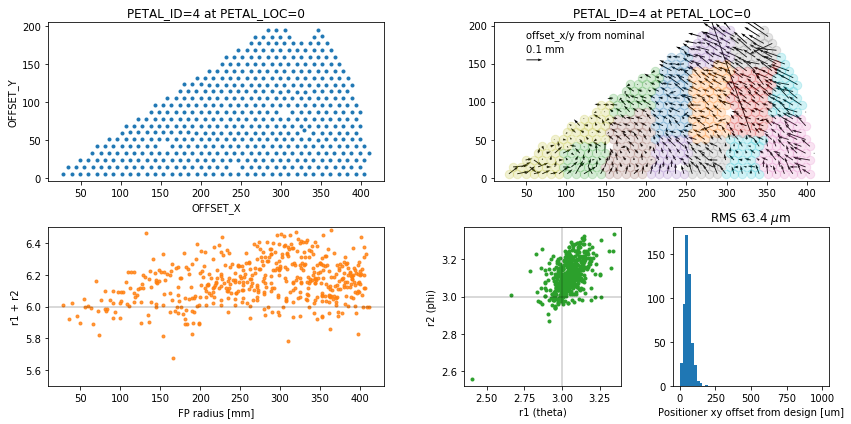

In [5]:
t0 = get_petal_calib(0)
plot_petal_calib(t0)

Getting calib for petal_id=5 installed at petal_loc=1


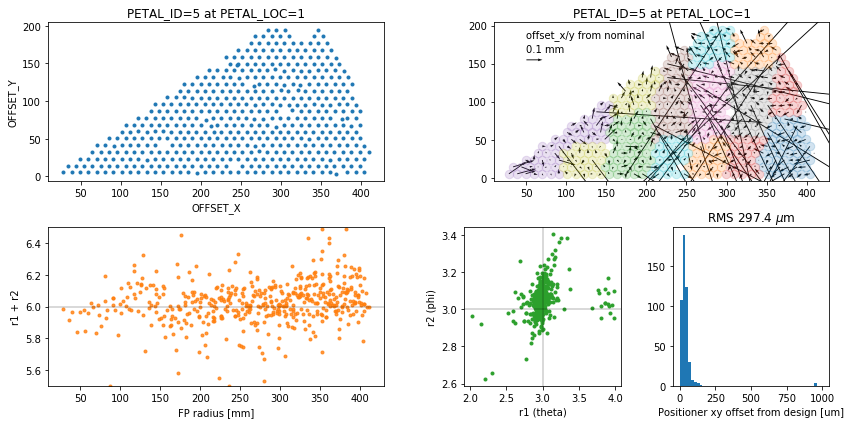

In [6]:
t1 = get_petal_calib(1)
plot_petal_calib(t1)

Getting calib for petal_id=6 installed at petal_loc=2


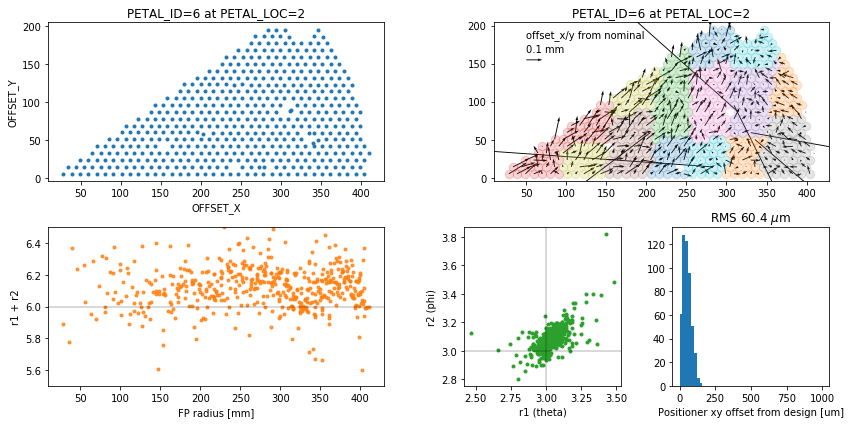

In [7]:
t2 = get_petal_calib(2)
plot_petal_calib(t2)

Getting calib for petal_id=3 installed at petal_loc=3


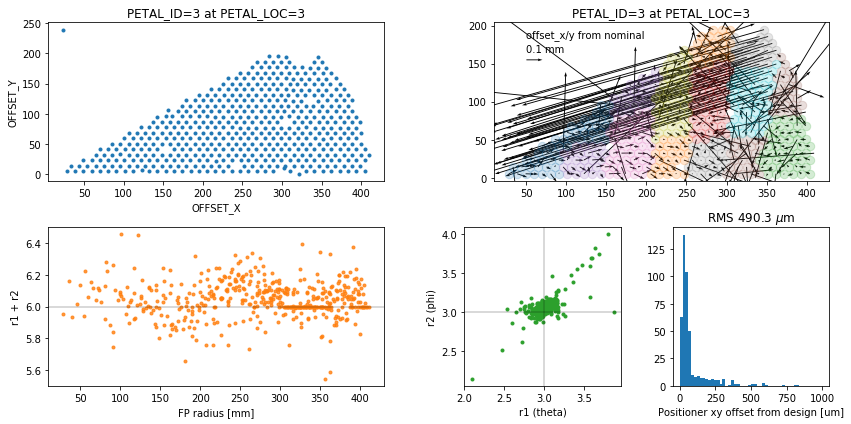

In [8]:
t3 = get_petal_calib(3)
plot_petal_calib(t3)

Getting calib for petal_id=8 installed at petal_loc=4


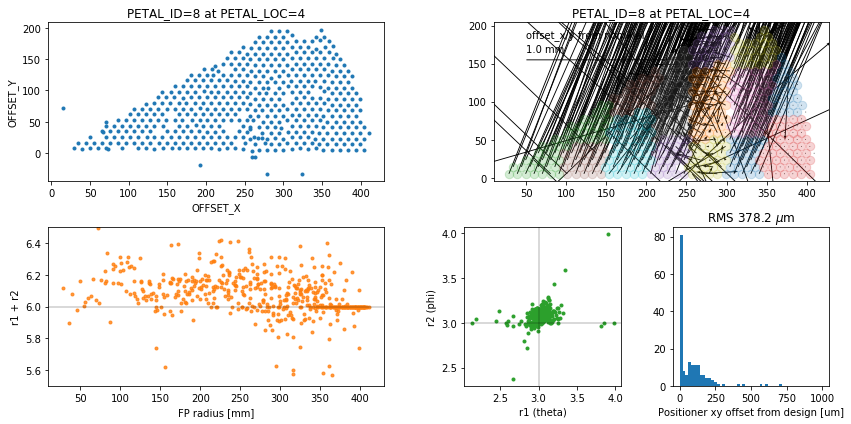

In [9]:
t4 = get_petal_calib(4)
plot_petal_calib(t4)

Getting calib for petal_id=10 installed at petal_loc=5


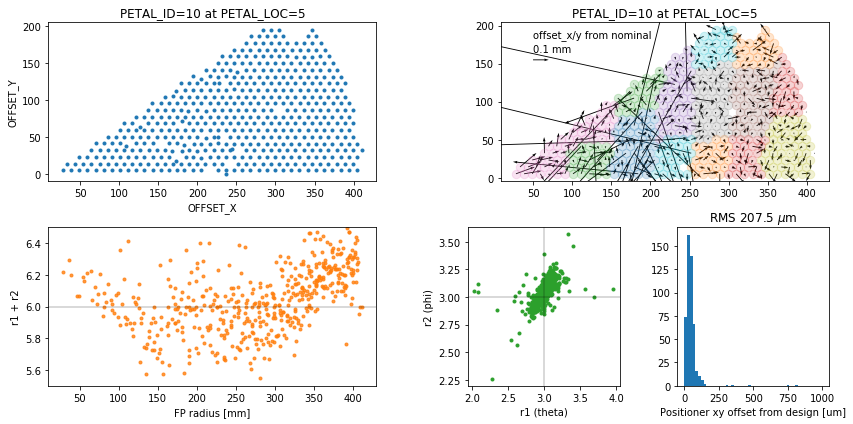

In [10]:
t5 = get_petal_calib(5)
plot_petal_calib(t5)

Getting calib for petal_id=9 installed at petal_loc=9


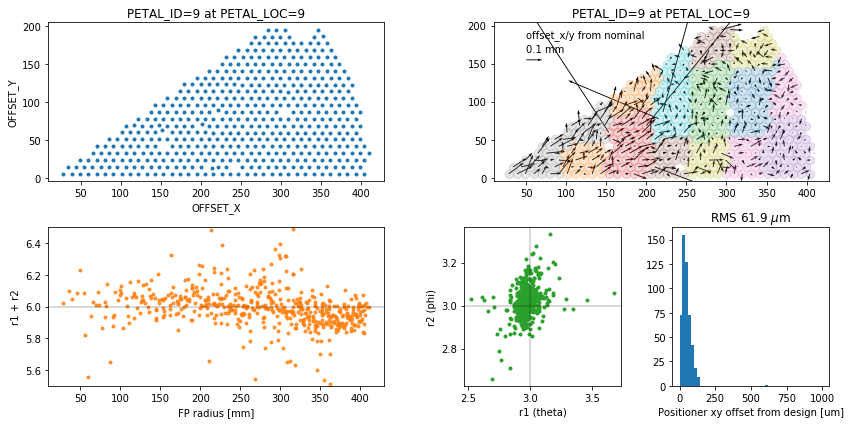

In [11]:
t9 = get_petal_calib(9)
plot_petal_calib(t9)

In [12]:
t0.colnames

['petal_id', 'device_loc', 'pos_id', 'time_recorded', 'r1', 'r2', 'x', 'y']

# Compare lab vs. KPNO arm length measurements

In [13]:
t0a = get_petal_calib(0, firstlast='first')
t0b = get_petal_calib(0, firstlast='last')

Getting calib for petal_id=4 installed at petal_loc=0
Getting calib for petal_id=4 installed at petal_loc=0


In [14]:
t0a.colnames

['petal_id', 'device_loc', 'pos_id', 'time_recorded', 'r1', 'r2', 'x', 'y']

Text(0.5,1,'KPNO measurements')

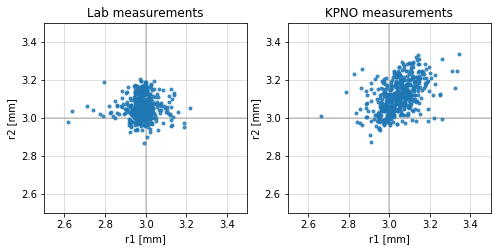

In [15]:
def plotr1r2(tx, color=None):
    axhline(3.0, color='k', alpha=0.2)
    axvline(3.0, color='k', alpha=0.2)
    plot(tx['r1'], tx['r2'], '.', color=color, alpha=0.8)
    xlabel('r1 [mm]')
    ylabel('r2 [mm]')
    xlim(2.5, 3.5); ylim(2.5, 3.5)
    grid()

    
figure(figsize=(8,3.5))
subplot(121)
plotr1r2(t0a)
title('Lab measurements')

subplot(122)
plotr1r2(t0b)
title('KPNO measurements')

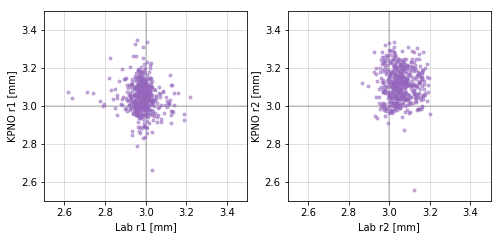

In [16]:
def plotrab(a, b, r='r1', color='C4'):
    axhline(3.0, color='k', alpha=0.2)
    axvline(3.0, color='k', alpha=0.2)
    plot(t0a[r], t0b[r], '.', alpha=0.5, color=color)
    xlabel('Lab {} [mm]'.format(r))
    ylabel('KPNO {} [mm]'.format(r))
    xlim(2.5, 3.5); ylim(2.5, 3.5)
    grid()


figure(figsize=(8,3.5))

subplot(121)
plotrab(t0a, t0b, 'r1')

subplot(122)
plotrab(t0a, t0b, 'r2')

Text(0,0.5,'KPNO r1+r2 [mm]')

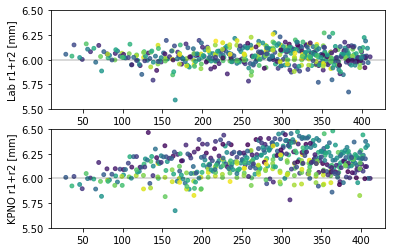

In [17]:
def plot_rr(tx):
    axhline(6.0, color='k', alpha=0.2)
    
    q = np.arctan2(tx['y'], tx['x'])
    
    rr = np.sqrt(tx['x']**2 + tx['y']**2)
    r12 = tx['r1'] + tx['r2']
    # plot(rr, r12, '.')
    scatter(rr, r12, c=q, s=15, alpha=0.8)
    ylim(5.5, 6.5)

subplot(211)
plot_rr(t0a)
ylabel('Lab r1+r2 [mm]')

subplot(212)
plot_rr(t0b)
ylabel('KPNO r1+r2 [mm]')

Text(0,0.5,'KPNO')

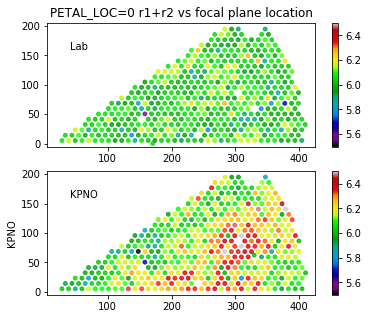

In [18]:
def plot_rxy(tx, label=None):
    r12 = tx['r1'] + tx['r2']
    scatter(tx['x'], tx['y'], c=r12, s=15, cmap='nipy_spectral',
            alpha=0.8, vmin=5.5, vmax=6.5)
    colorbar()
    xlim(5, 425)
    ylim(-5, 205)
    if label is not None:
        text(40, 160, label)

figure(figsize=(6,5))
subplot(211)
plot_rxy(t0a, label='Lab')
title('PETAL_LOC=0 r1+r2 vs focal plane location')

subplot(212)
plot_rxy(t0b, label='KPNO')
ylabel('KPNO')


In [19]:
tx = dict()
for p in (0,1,2,3,4,5):
    tx['lab'+str(p)] = get_petal_calib(p, firstlast='first')
    tx['kpno'+str(p)] = get_petal_calib(p, firstlast='last')
    
#- Replace the lab x,y locations with the KPNO locations since some petals
#- have their first entries uploaded with the square teststand pattern
for p in (0,1,2,3,4,5):
    tx['lab'+str(p)]['x'] = tx['kpno'+str(p)]['x']
    tx['lab'+str(p)]['y'] = tx['kpno'+str(p)]['y']


Getting calib for petal_id=4 installed at petal_loc=0
Getting calib for petal_id=4 installed at petal_loc=0
Getting calib for petal_id=5 installed at petal_loc=1
Getting calib for petal_id=5 installed at petal_loc=1
Getting calib for petal_id=6 installed at petal_loc=2
Getting calib for petal_id=6 installed at petal_loc=2
Getting calib for petal_id=3 installed at petal_loc=3
Getting calib for petal_id=3 installed at petal_loc=3
Getting calib for petal_id=8 installed at petal_loc=4
Getting calib for petal_id=8 installed at petal_loc=4
Getting calib for petal_id=10 installed at petal_loc=5
Getting calib for petal_id=10 installed at petal_loc=5


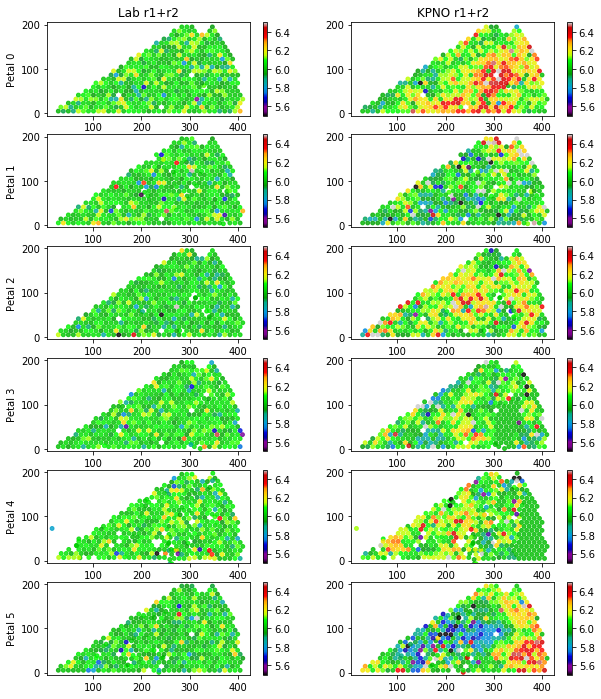

In [20]:
figure(figsize=(10,12))
petals = (0,1,2,3,4,5)
for p in (0,1,2,3,4,5):
    subplot(len(petals), 2, 1+2*p)
    plot_rxy(tx['lab'+str(p)])
    ylabel('Petal {}'.format(p))
    if p == 0:
        title('Lab r1+r2')
    subplot(len(petals), 2, 2+2*p)
    plot_rxy(tx['kpno'+str(p)])
    if p == 0:
        title('KPNO r1+r2')

In [21]:
len(tx['lab1'])

502